# Linear Regression Starter Kit for Kaggle House Prices 

## Imports and inits

In [1]:
import h2o
h2o.init(max_mem_size='12G') # give h2o as much memory as possible
h2o.remove_all()
h2o.no_progress() # turn off h2o progress bars

import numpy as np
import pandas as pd

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_112"; Java(TM) SE Runtime Environment (build 1.8.0_112-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.112-b16, mixed mode)
  Starting server from /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpvjg9815f
  JVM stdout: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpvjg9815f/h2o_phall_started_from_python.out
  JVM stderr: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpvjg9815f/h2o_phall_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster version:,3.10.0.10
H2O cluster version age:,6 months and 17 days !!!
H2O cluster name:,H2O_from_python_phall_vzjnrf
H2O cluster total nodes:,1
H2O cluster free memory:,10.67 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


## Import data

In [2]:
train = h2o.import_file('../data/train.csv')
test = h2o.import_file('../data/test.csv')

#### Determine data types

In [3]:
def get_type_lists(frame=train, rejects=['Id', 'SalePrice']):

    """Creates lists of numeric and categorical variables.
    
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.
    
    """
    
    nums, cats = [], []
    for key, val in frame.types.items():
        if key not in rejects:
            if val == 'enum':
                cats.append(key)
            else: 
                nums.append(key)
                
    print('Numeric =', nums)                
    print()
    print('Categorical =', cats)
    
    return nums, cats

In [4]:
original_nums, cats = get_type_lists()

Numeric = ['FullBath', 'TotalBsmtSF', 'LowQualFinSF', 'TotRmsAbvGrd', 'EnclosedPorch', 'LotArea', 'WoodDeckSF', 'GrLivArea', 'HalfBath', 'GarageArea', 'MiscVal', 'MSSubClass', '3SsnPorch', 'OpenPorchSF', 'YearBuilt', 'BsmtFullBath', '1stFlrSF', 'GarageCars', '2ndFlrSF', 'BsmtHalfBath', 'OverallQual', 'OverallCond', 'BsmtFinSF2', 'MoSold', 'YrSold', 'KitchenAbvGr', 'YearRemodAdd', 'GarageYrBlt', 'Fireplaces', 'LotFrontage', 'MasVnrArea', 'BsmtUnfSF', 'BsmtFinSF1', 'ScreenPorch', 'PoolArea', 'BedroomAbvGr']

Categorical = ['BsmtExposure', 'HeatingQC', 'Electrical', 'BsmtFinType1', 'LandSlope', 'Foundation', 'GarageCond', 'HouseStyle', 'Street', 'LotConfig', 'Heating', 'GarageFinish', 'Utilities', 'Alley', 'GarageQual', 'GarageType', 'Neighborhood', 'ExterQual', 'BsmtFinType2', 'CentralAir', 'ExterCond', 'MiscFeature', 'Exterior1st', 'KitchenQual', 'MasVnrType', 'BsmtCond', 'LotShape', 'MSZoning', 'SaleType', 'FireplaceQu', 'PoolQC', 'Exterior2nd', 'LandContour', 'Condition1', 'RoofStyle'

## Impute numeric missing

In [5]:
# median usually better than mean
# (_ signifies temporary throw-away variable, used to suppress output)
_ = train[['MasVnrArea', 'GarageYrBlt', 'LotFrontage']].impute(method='median')
_ = test[['BsmtHalfBath', 'BsmtFinSF1', 'BsmtFullBath', 'BsmtFinSF2', 'BsmtUnfSF', 'MasVnrArea', 
          'GarageYrBlt', 'LotFrontage', 'GarageCars', 'TotalBsmtSF', 'GarageArea']].impute(method='median')

## Encode categorical using shrunken averages
http://helios.mm.di.uoa.gr/~rouvas/ssi/sigkdd/sigkdd.vol3.1/barreca.ps

In [6]:
def target_encoder(training_frame, test_frame, x, y, lambda_=0.15, threshold=150, test=False):
    
    """ Applies simple target encoding to categorical variables.
    
    :param training_frame: Training frame which to create target means and to be encoded.
    :param test_frame: Test frame to be encoded using information from training frame.
    :param x: Name of input variable to be encoded.
    :param y: Name of target variable to use for encoding.
    :param lambda_: Balance between level mean and overall mean for small groups.
    :param threshold: Number below which a level is considered small enough to be shrunken.
    :param test: Whether or not to print the row_val_dict for testing purposes.
    :return: Tuple of encoded variable from train and test set as H2OFrames. 
    
    """
    
    # convert to pandas
    trdf = training_frame.as_data_frame().loc[:, [x,y]] # df
    tss = test_frame.as_data_frame().loc[:, x]          # series

    
    # create dictionary of level:encode val
    
    encode_name = x + '_Tencode'
    overall_mean = trdf[y].mean()
    row_val_dict = {}

    for level in trdf[x].unique():
        level_df = trdf[trdf[x] == level][y]
        level_n = level_df.shape[0]
        level_mean = level_df.mean()
        if level_n >= threshold:
            row_val_dict[level] = level_mean
        else:
            row_val_dict[level] = ((1 - lambda_) * level_mean) +\
                                  (lambda_ * overall_mean)
                
    row_val_dict[np.nan] = overall_mean # handle missing values
    
    if test:
        print(row_val_dict)
        
    # apply the transform to training data
    trdf[encode_name] = trdf[x].apply(lambda i: row_val_dict[i])   
    
    # apply the transform to test data
    tsdf = pd.DataFrame(columns=[x, encode_name])
    tsdf[x] = tss
    tsdf.loc[:, encode_name] = overall_mean # handle previously unseen values
    tsdf[encode_name] = tsdf[x].apply(lambda i: row_val_dict[i])
    
    # convert back to H2O
    
    trdf = h2o.H2OFrame(trdf[encode_name].as_matrix())
    trdf.columns = [encode_name]
    
    tsdf = h2o.H2OFrame(tsdf[encode_name].as_matrix())
    tsdf.columns = [encode_name]
    
    return (trdf, tsdf)


#### Execute encoding

In [7]:
for i, var in enumerate(cats):
    
    total = len(cats)
    tr_enc, ts_enc = target_encoder(train, test, var, 'SalePrice')

    print('Encoding: ' + var + ' (' + str(i+1) + '/' + str(total) + ') ...')

    train = train.cbind(tr_enc)
    test = test.cbind(ts_enc)    
    
print('Done.')

Encoding: BsmtExposure (1/43) ...
Encoding: HeatingQC (2/43) ...
Encoding: Electrical (3/43) ...
Encoding: BsmtFinType1 (4/43) ...
Encoding: LandSlope (5/43) ...
Encoding: Foundation (6/43) ...
Encoding: GarageCond (7/43) ...
Encoding: HouseStyle (8/43) ...
Encoding: Street (9/43) ...
Encoding: LotConfig (10/43) ...
Encoding: Heating (11/43) ...
Encoding: GarageFinish (12/43) ...
Encoding: Utilities (13/43) ...
Encoding: Alley (14/43) ...
Encoding: GarageQual (15/43) ...
Encoding: GarageType (16/43) ...
Encoding: Neighborhood (17/43) ...
Encoding: ExterQual (18/43) ...
Encoding: BsmtFinType2 (19/43) ...
Encoding: CentralAir (20/43) ...
Encoding: ExterCond (21/43) ...
Encoding: MiscFeature (22/43) ...
Encoding: Exterior1st (23/43) ...
Encoding: KitchenQual (24/43) ...
Encoding: MasVnrType (25/43) ...
Encoding: BsmtCond (26/43) ...
Encoding: LotShape (27/43) ...
Encoding: MSZoning (28/43) ...
Encoding: SaleType (29/43) ...
Encoding: FireplaceQu (30/43) ...
Encoding: PoolQC (31/43) ...
En

#### Redefine numerics and explore

In [8]:
encoded_nums, cats = get_type_lists(frame=train)

Numeric = ['FullBath', 'TotalBsmtSF', 'MiscFeature_Tencode', 'LowQualFinSF', 'TotRmsAbvGrd', 'EnclosedPorch', 'LotArea', 'WoodDeckSF', 'LandSlope_Tencode', 'GrLivArea', 'BsmtQual_Tencode', 'SaleCondition_Tencode', 'BsmtFinType2_Tencode', 'GarageType_Tencode', 'HalfBath', 'GarageArea', 'BsmtFinType1_Tencode', 'MiscVal', 'Street_Tencode', 'MSSubClass', 'GarageFinish_Tencode', 'LotShape_Tencode', '3SsnPorch', 'Neighborhood_Tencode', 'OpenPorchSF', 'Fence_Tencode', 'RoofMatl_Tencode', 'BsmtCond_Tencode', 'Alley_Tencode', 'MasVnrType_Tencode', 'PavedDrive_Tencode', 'YearBuilt', 'RoofStyle_Tencode', 'OverallCond', 'BsmtFullBath', '1stFlrSF', 'GarageCars', '2ndFlrSF', 'LotConfig_Tencode', 'BsmtExposure_Tencode', 'BsmtHalfBath', 'OverallQual', 'MasVnrArea', 'Condition1_Tencode', 'BsmtFinSF2', 'MoSold', 'HouseStyle_Tencode', 'CentralAir_Tencode', 'YrSold', 'ExterQual_Tencode', 'FireplaceQu_Tencode', 'BsmtUnfSF', 'KitchenAbvGr', 'Exterior2nd_Tencode', 'PoolQC_Tencode', 'YearRemodAdd', 'GarageYrB

In [9]:
print('Imputed and encoded numeric training data:')
train[encoded_nums].describe() #79 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric test data:')
test[encoded_nums].describe() #79 numeric columns w/ no missing

Imputed and encoded numeric training data:
Rows:1460
Cols:79




,FullBath,TotalBsmtSF,MiscFeature_Tencode,LowQualFinSF,TotRmsAbvGrd,EnclosedPorch,LotArea,WoodDeckSF,LandSlope_Tencode,GrLivArea,BsmtQual_Tencode,SaleCondition_Tencode,BsmtFinType2_Tencode,GarageType_Tencode,HalfBath,GarageArea,BsmtFinType1_Tencode,MiscVal,Street_Tencode,MSSubClass,GarageFinish_Tencode,LotShape_Tencode,3SsnPorch,Neighborhood_Tencode,OpenPorchSF,Fence_Tencode,RoofMatl_Tencode,BsmtCond_Tencode,Alley_Tencode,MasVnrType_Tencode,PavedDrive_Tencode,YearBuilt,RoofStyle_Tencode,OverallCond,BsmtFullBath,1stFlrSF,GarageCars,2ndFlrSF,LotConfig_Tencode,BsmtExposure_Tencode,BsmtHalfBath,OverallQual,MasVnrArea,Condition1_Tencode,BsmtFinSF2,MoSold,HouseStyle_Tencode,CentralAir_Tencode,YrSold,ExterQual_Tencode,FireplaceQu_Tencode,BsmtUnfSF,KitchenAbvGr,Exterior2nd_Tencode,PoolQC_Tencode,YearRemodAdd,GarageYrBlt,MSZoning_Tencode,LandContour_Tencode,Fireplaces,HeatingQC_Tencode,LotFrontage,SaleType_Tencode,Utilities_Tencode,Condition2_Tencode,Functional_Tencode,GarageCond_Tencode,BldgType_Tencode,Foundation_Tencode,GarageQual_Tencode,KitchenQual_Tencode,Heating_Tencode,Electrical_Tencode,Exterior1st_Tencode,BsmtFinSF1,ScreenPorch,PoolArea,ExterCond_Tencode,BedroomAbvGr
type,int,int,real,int,int,int,int,int,real,int,real,real,real,real,int,int,real,int,real,int,real,real,int,real,int,real,real,real,real,real,real,int,real,int,int,int,int,int,real,real,int,int,real,real,int,int,real,real,int,real,real,int,int,real,real,int,real,real,real,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int,int,int,real,int
mins,0.0,0.0,107038.17938356163,0.0,2.0,0.0,1300.0,0.0,179956.7995658466,334.0,125476.40366927591,115644.42938356163,155574.02938356163,120605.97382800607,0.0,0.0,151994.04028581732,0.0,137800.10438356164,20.0,142156.42314049587,164754.81837837838,0.0,110928.17938356163,0.0,141281.58847447074,143588.17938356166,81538.17938356164,131024.39738356163,151508.53605022831,124921.43327245054,1872.0,153710.9066562889,1.0,0.0,334.0,0.0,0.0,176938.0475285171,165652.29590766,0.0,1.0,0.0,141966.09605022828,0.0,1.0,120765.67938356163,116612.64201514059,2006.0,101925.61152641877,137437.70688356162,0.0,0.0,116388.17938356163,180921.19589041095,1950.0,1900.0,90486.97938356163,148776.6468438791,0.0,101088.17938356164,21.0,129010.67938356163,144013.17938356166,109375.67938356163,100068.17938356164,119363.17938356163,136305.59873840035,118398.96063356163,112279.84605022831,116868.60374253601,88763.17938356164,84088.17938356164,87488.17938356164,0.0,0.0,0.0,92163.17938356164,0.0
mean,1.5650684931506849,1057.4294520547944,180000.13846481516,5.844520547945206,6.517808219178082,21.954109589041096,10516.828082191782,94.2445205479452,180784.26482323135,1515.463698630137,181246.74738478137,180217.29174554325,182969.4818640458,184682.71746706698,0.38287671232876713,472.9801369863014,183992.5769034997,43.489041095890414,180952.46823719272,56.897260273972606,185226.61840213925,180636.96109490524,3.4095890410958902,180373.08053504408,46.66027397260274,175820.09948517545,180756.55353696752,182907.7643074686,178903.9882177238,179556.69860888534,181680.14683289544,1971.267808219178,180930.1805271627,5.575342465753424,0.42534246575342466,1162.626712328767,1.7671232876712328,346.99246575342465,180509.66312370988,181624.85937051979,0.057534246575342465,6.0993150684931505,103.68526170798899,181383.89587446052,46.54931506849315,6.321917808219178,181286.7320662882,181659.6301311222,2007.8157534246575,180058.82286939386,199396.0979636423,567.2404109589041,1.0465753424657533,181031.77015866013,181358.14341400826,1984.8657534246574,1978.5061638868744,180890.65145472885,180821.86755352785,0.613013698630137,181217.80597203973,70.04995836802664,179942.3916239914,180925.6569721805,180958.04482243385,181271.62194407952,185529.6042633233,181528.18075483205,181839.7781230531,185465.54685972977,179706.3537221336,181082.57937689996,181738.1697731751,180880.5669704916,443.6397260273973,15.060958904109588,2.758904109589041,181331.30861662602,2.86643835616

--------------------------------------------------------------------------------
Imputed and encoded numeric test data:
Rows:1459
Cols:79




,FullBath,TotalBsmtSF,MiscFeature_Tencode,LowQualFinSF,TotRmsAbvGrd,EnclosedPorch,LotArea,WoodDeckSF,LandSlope_Tencode,GrLivArea,BsmtQual_Tencode,SaleCondition_Tencode,BsmtFinType2_Tencode,GarageType_Tencode,HalfBath,GarageArea,BsmtFinType1_Tencode,MiscVal,Street_Tencode,MSSubClass,GarageFinish_Tencode,LotShape_Tencode,3SsnPorch,Neighborhood_Tencode,OpenPorchSF,Fence_Tencode,RoofMatl_Tencode,BsmtCond_Tencode,Alley_Tencode,MasVnrType_Tencode,PavedDrive_Tencode,YearBuilt,RoofStyle_Tencode,OverallCond,BsmtFullBath,1stFlrSF,GarageCars,2ndFlrSF,LotConfig_Tencode,BsmtExposure_Tencode,BsmtHalfBath,OverallQual,MasVnrArea,Condition1_Tencode,BsmtFinSF2,MoSold,HouseStyle_Tencode,CentralAir_Tencode,YrSold,ExterQual_Tencode,FireplaceQu_Tencode,BsmtUnfSF,KitchenAbvGr,Exterior2nd_Tencode,PoolQC_Tencode,YearRemodAdd,GarageYrBlt,MSZoning_Tencode,LandContour_Tencode,Fireplaces,HeatingQC_Tencode,LotFrontage,SaleType_Tencode,Utilities_Tencode,Condition2_Tencode,Functional_Tencode,GarageCond_Tencode,BldgType_Tencode,Foundation_Tencode,GarageQual_Tencode,KitchenQual_Tencode,Heating_Tencode,Electrical_Tencode,Exterior1st_Tencode,BsmtFinSF1,ScreenPorch,PoolArea,ExterCond_Tencode,BedroomAbvGr
type,int,real,real,int,int,int,int,int,real,int,real,real,real,real,int,real,real,int,real,int,real,real,int,real,int,real,real,real,real,real,real,int,real,int,real,int,real,int,real,real,real,int,real,real,real,int,real,real,int,real,real,real,int,real,real,int,real,real,real,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int,int,real,int
mins,0.0,0.0,107038.17938356163,0.0,3.0,0.0,1470.0,0.0,179956.7995658466,407.0,125476.40366927591,115644.42938356163,155574.02938356163,120605.97382800607,0.0,0.0,151994.04028581732,0.0,137800.10438356164,20.0,142156.42314049587,164754.81837837838,0.0,110928.17938356163,0.0,141281.58847447074,179803.6792189679,81538.17938356164,131024.39738356163,151508.53605022831,124921.43327245054,1879.0,153710.9066562889,1.0,0.0,407.0,0.0,0.0,176938.0475285171,165652.29590766,0.0,1.0,0.0,141966.09605022828,0.0,1.0,120765.67938356163,116612.64201514059,2006.0,101925.61152641877,137437.70688356162,0.0,0.0,116388.17938356163,180921.19589041095,1950.0,1895.0,90486.97938356163,148776.6468438791,0.0,101088.17938356164,21.0,129010.67938356163,180921.19589041095,117663.17938356163,100068.17938356164,119363.17938356163,136305.59873840035,118398.96063356163,112279.84605022831,116868.60374253601,91118.89366927592,109871.51271689495,87488.17938356164,0.0,0.0,0.0,92163.17938356164,0.0
mean,1.570938999314599,1046.1179698216736,180005.30438727606,3.5435229609321452,6.385195339273475,24.24331734064427,9819.161069225496,93.17477724468814,180592.19026393845,1486.0459218642907,181935.06349994175,179879.1401656116,183200.1159337163,184656.7295734541,0.3776559287183002,472.7688614540466,184645.88361245434,58.16792323509253,180952.34618765383,57.37834132967786,184827.78985491671,180249.28067462493,1.794379712131597,178691.2305139906,48.3139136394791,175663.07479793802,180110.94715035174,182176.8367729062,178248.7290662322,178895.07396658702,180094.9269028509,1971.357779300891,180180.92858796637,5.5538039753255655,0.4344543582704186,1156.534612748458,1.7661179698216736,325.9677861549006,180234.81382594892,181657.00791990335,0.06520247083047358,6.078821110349555,100.70914127423823,181389.31663321095,52.61934156378601,6.104180945853324,180645.5075029316,181370.41046901883,2007.7697052775875,180460.36175619633,197633.5311456587,554.2949245541838,1.0424948594928032,180766.37959959693,181293.60332733998,1983.6627827278958,1977.7212165097756,179772.8336670903,181450.84022501088,0.5812200137080192,181724.34342026233,68.58035714285714,179613.55995767802,180950.9160234005,181166.03732137335,181323.9571258677,185422.7774534009,181077.96729000125,182394.1607868111,184312.7546957362,179420.17532378223,181709.8782401401,181890.53298830043,180163.89739622173,439.2037037037037,17.064427690198766,1.7443454420836186,180735.6325431525,2.85400959561

In [10]:
# Check Neighborhood_Tencode

print(test[0:5, ['Neighborhood', 'Neighborhood_Tencode']])
_, _ = target_encoder(train, test, 'Neighborhood', 'SalePrice', test=True)
del _

# NAmes   145847
# NAmes   145847
# Gilbert 191064
# Gilbert 191064
# StoneBr 291062

Neighborhood,Neighborhood_Tencode
NAmes,145847
NAmes,145847
Gilbert,191065
Gilbert,191065
StoneBr,291062



{nan: 180921.19589041095, 'OldTown': 136129.68513577402, 'MeadowV': 110928.17938356164, 'Veenker': 230094.99756537983, 'Sawyer': 143412.3442484265, 'NoRidge': 312139.1988957568, 'NridgHt': 295968.20925369154, 'CollgCr': 197965.77333333335, 'Crawfor': 206169.19605022832, 'NWAmes': 187830.7376027397, 'Blueste': 144013.17938356166, 'StoneBr': 291062.3293835616, 'Edwards': 136124.92438356165, 'Timber': 233048.5096467195, 'BrkSide': 133247.12334907887, 'IDOTRR': 112243.39559977785, 'NAmes': 145847.08, 'BrDale': 115957.86688356164, 'Blmngtn': 192778.42938356166, 'Somerst': 218711.04101146862, 'ClearCr': 207818.79366927594, 'NPkVill': 148428.4571613394, 'Gilbert': 191064.5097633085, 'SawyerW': 185710.60650220572, 'Mitchel': 159967.78346519428, 'SWISU': 148340.8353835616}


## Create combination features

In [11]:
def feature_combiner(training_frame, test_frame, nums):
    
    """ Combines numeric features using simple arithmatic operations.
    
    :param training_frame: Training frame from which to generate features and onto which generated 
                           feeatures will be cbound.
    :param test_frame: Test frame from which to generate features and onto which generated 
                       feeatures will be cbound.
    :param nums: List of original numeric features from which to generate combined features.
    
    """

    total = len(nums)
    
    # convert to pandas
    train_df = training_frame.as_data_frame()
    test_df = test_frame.as_data_frame()
    
    for i, col_i in enumerate(nums):
        
        print('Combining: ' + col_i + ' (' + str(i+1) + '/' + str(total) + ') ...')        
        
        for j, col_j in enumerate(nums):
            
            # don't repeat (i*j = j*i)
            if i < j:
                
                # convert to pandas
                col_i_train_df = train_df[col_i]
                col_j_train_df = train_df[col_j]
                col_i_test_df = test_df[col_i]
                col_j_test_df = test_df[col_j] 

                # multiply, convert back to h2o
                train_df[str(col_i + '|' + col_j)] = col_i_train_df.values*col_j_train_df.values
                test_df[str(col_i + '|' + col_j)] = col_i_test_df.values*col_j_test_df.values
                
    print('Done.')
    
    # convert back to h2o
    
    print('Converting to H2OFrame ...')
    
    training_frame = h2o.H2OFrame(train_df)
    training_frame.columns = list(train_df)
    test_frame = h2o.H2OFrame(test_df)
    test_frame.columns = list(test_df)
    
    print('Done.')
    
    # conserve memory 
    del train_df
    del test_df 
    
    return training_frame, test_frame


In [12]:
train, test = feature_combiner(train, test, encoded_nums)

Combining: FullBath (1/79) ...
Combining: TotalBsmtSF (2/79) ...
Combining: MiscFeature_Tencode (3/79) ...
Combining: LowQualFinSF (4/79) ...
Combining: TotRmsAbvGrd (5/79) ...
Combining: EnclosedPorch (6/79) ...
Combining: LotArea (7/79) ...
Combining: WoodDeckSF (8/79) ...
Combining: LandSlope_Tencode (9/79) ...
Combining: GrLivArea (10/79) ...
Combining: BsmtQual_Tencode (11/79) ...
Combining: SaleCondition_Tencode (12/79) ...
Combining: BsmtFinType2_Tencode (13/79) ...
Combining: GarageType_Tencode (14/79) ...
Combining: HalfBath (15/79) ...
Combining: GarageArea (16/79) ...
Combining: BsmtFinType1_Tencode (17/79) ...
Combining: MiscVal (18/79) ...
Combining: Street_Tencode (19/79) ...
Combining: MSSubClass (20/79) ...
Combining: GarageFinish_Tencode (21/79) ...
Combining: LotShape_Tencode (22/79) ...
Combining: 3SsnPorch (23/79) ...
Combining: Neighborhood_Tencode (24/79) ...
Combining: OpenPorchSF (25/79) ...
Combining: Fence_Tencode (26/79) ...
Combining: RoofMatl_Tencode (27/79

#### Redefine numerics and explore

In [13]:
encoded_combined_nums, cats = get_type_lists(frame=train)

Numeric = ['MiscFeature_Tencode|YrSold', 'BsmtFullBath|Functional_Tencode', 'MiscFeature_Tencode|GarageQual_Tencode', 'LotShape_Tencode|Utilities_Tencode', 'TotalBsmtSF|Condition1_Tencode', 'SaleCondition_Tencode|SaleType_Tencode', 'GrLivArea|ScreenPorch', 'GarageFinish_Tencode|YrSold', 'Street_Tencode|YearBuilt', 'Fence_Tencode|MSZoning_Tencode', 'WoodDeckSF|BsmtFullBath', 'BsmtUnfSF|Exterior2nd_Tencode', 'EnclosedPorch|LandContour_Tencode', 'LowQualFinSF|BsmtExposure_Tencode', 'Street_Tencode|GarageCars', 'Street_Tencode|MSSubClass', 'HalfBath|Foundation_Tencode', 'GarageFinish_Tencode|MoSold', 'KitchenAbvGr|KitchenQual_Tencode', 'LotArea|Fireplaces', 'BsmtHalfBath|Exterior2nd_Tencode', 'MiscFeature_Tencode', 'GarageFinish_Tencode|Condition1_Tencode', 'Street_Tencode|HouseStyle_Tencode', 'MiscFeature_Tencode|GarageType_Tencode', 'Street_Tencode|CentralAir_Tencode', 'GarageArea|PoolArea', 'Condition1_Tencode|Exterior1st_Tencode', 'LandSlope_Tencode|HeatingQC_Tencode', 'BsmtCond_Tencod

In [14]:
# check number of created variables is correct
# 1 id column, 1 target column, 79 original + encoded numeric columns, 43 original categorical variables
# sum(range(1, 79)) combined variables
print(train.shape == (1460, sum(range(1, 79), (79 + 43 + 1 + 1))))
print(test.shape == (1459, sum(range(1, 79), (79 + 43 + 1))))

True
True


In [15]:
# check multiplication for a random column
ridx = np.random.choice(sum(range(1, 79)))
combined_only = [name for name in encoded_combined_nums if name not in encoded_nums]
combined_check_vars = combined_only[ridx].split('|')
combined_check_vars.append(combined_only[ridx])

print(train[736, combined_check_vars])
print(test[637, combined_check_vars])

print(train[736, combined_check_vars[0]]*train[736, combined_check_vars[1]])
print(test[637, combined_check_vars[0]]*test[637, combined_check_vars[1]])

RoofMatl_Tencode,BldgType_Tencode,RoofMatl_Tencode|BldgType_Tencode
179804,140648,2.5289e+10


RoofMatl_Tencode,BldgType_Tencode,RoofMatl_Tencode|BldgType_Tencode
179804,185764,3.3401e+10



25289044914.456295
33401016032.117096


## Train constituent models (for inspection purposes)

In [16]:
h2o.show_progress()                                          # turn on progress bars
from h2o.estimators.glm import H2OGeneralizedLinearEstimator # import GLM models
from h2o.grid.grid_search import H2OGridSearch               # grid search

SalePrice
12.2477
12.109
12.3172


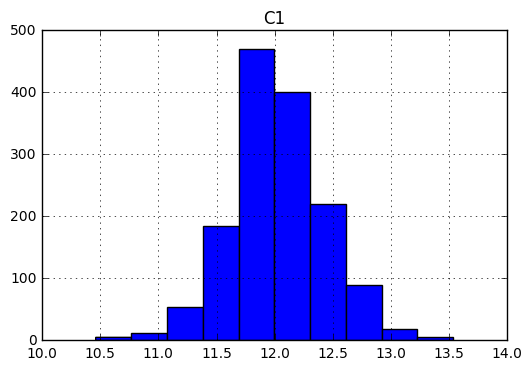

In [17]:
# Check log transform - looks good
%matplotlib inline
train['SalePrice'].log().as_data_frame().hist()

# Execute log transform
train['SalePrice'] = train['SalePrice'].log()
print(train[0:3, 'SalePrice'])

#### Split training data

In [18]:
base_train, base_valid, stack_train, stack_valid = train.split_frame([0.3, 0.2, 0.3], seed=12345)
print(base_train.shape)
print(base_valid.shape)
print(stack_train.shape)
print(stack_valid.shape)

(441, 3205)
(297, 3205)
(425, 3205)
(297, 3205)


#### Define model with grid search function

In [19]:
def glm_grid(X, y, train, valid):
    
    """ Wrapper function for penalized GLM with alpha and lambda search.
    
    :param X: List of inputs.
    :param y: Name of target variable.
    :param train: Name of training H2OFrame.
    :param valid: Name of validation H2OFrame.
    :return: Best H2Omodel from H2OGeneralizedLinearEstimator

    """
    
    alpha_opts = [0.01, 0.25, 0.5, 0.99] # always keep some L2
    hyper_parameters = {"alpha":alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(
            family="gaussian",
            lambda_search=True,
            seed=12345),
        hyper_params=hyper_parameters)
    
    # train grid
    grid.train(y=y,
               x=X, 
               training_frame=train,
               validation_frame=valid)

    # show grid search results
    print(grid.show())

    best = grid.get_grid()[0]
    print(best)
    
    # plot top frame values
    yhat_frame = valid.cbind(best.predict(valid))
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')
    
    # select best model
    return best


## Train base level models

#### First model on original numeric inputs

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.25]  Grid_GLM_py_191_sid_8fab_model_python_1495746557457_1_model_1   
1     [0.5]  Grid_GLM_py_191_sid_8fab_model_python_1495746557457_1_model_2   
2    [0.99]  Grid_GLM_py_191_sid_8fab_model_python_1495746557457_1_model_3   
3    [0.01]  Grid_GLM_py_191_sid_8fab_model_python_1495746557457_1_model_0   

    residual_deviance  
0  6.1547872644675135  
1   6.176742787271307  
2    6.18777456413037  
3   6.222185404213095  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_191_sid_8fab_model_python_1495746557457_1_model_1
GLM Model: summary



,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,"Elastic Net (alpha = 0.25, lambda = 0.02277 )","nlambda = 100, lambda.max = 1.3649, lambda.min = 0.02277, lambda.1se = -1.0",36,24,0,py_191_sid_8fab




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.030433677244580275
RMSE: 0.17445250713182736
MAE: 0.11944477286438474
RMSLE: 0.013420792192346001
R^2: 0.8278683153607944
Mean Residual Deviance: 0.030433677244580275
Null degrees of freedom: 440
Residual degrees of freedom: 416
Null deviance: 77.97083780937984
Residual deviance: 13.421251664859902
AIC: -236.55883023211004

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 0.02072318944265156
RMSE: 0.14395551202594348
MAE: 0.11068256137484296
RMSLE: 0.011125353076463345
R^2: 0.8607616808886678
Mean Residual Deviance: 0.02072318944265156
Null degrees of freedom: 296
Residual degrees of freedom: 272
Null deviance: 44.26529427591359
Residual deviance: 6.1547872644675135
AIC: -256.4715882901204
Scoring History: 


,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-05-25 17:10:01,0.000 sec,0,.13E1,2,0.1715065,0.1442587
,2017-05-25 17:10:01,0.002 sec,0,.12E1,2,0.1663340,0.1395944
,2017-05-25 17:10:01,0.003 sec,0,.12E1,2,0.1612922,0.1350533
,2017-05-25 17:10:01,0.004 sec,0,.11E1,2,0.1563858,0.1306395
,2017-05-25 17:10:01,0.006 sec,0,.11E1,2,0.1516189,0.1263565
---,---,---,---,---,---,---,---
,2017-05-25 17:10:01,0.127 sec,0,.16E-1,26,0.0300759,0.0207583
,2017-05-25 17:10:01,0.128 sec,0,.16E-1,26,0.0300370,0.0207626
,2017-05-25 17:10:01,0.130 sec,0,.15E-1,26,0.0300004,0.0207676
,2017-05-25 17:10:01,0.131 sec,0,.14E-1,26,0.0299672,0.0207743



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
12.109,12.2194
11.7745,12.1191
11.964,11.8372
12.6925,12.6562
11.9447,11.9856
12.1002,12.2708
12.6411,12.6413
11.8776,11.8451
11.7772,11.7651
12.428,12.3933


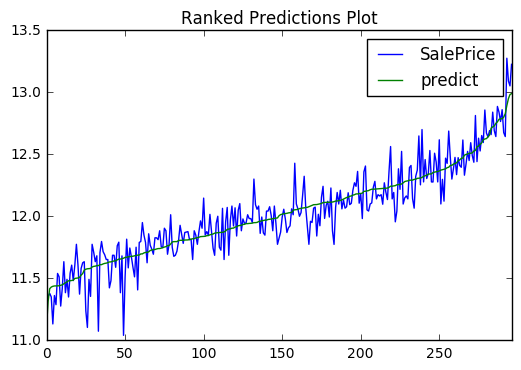

In [20]:
glm0 = glm_grid(original_nums, 'SalePrice', base_train, base_valid)

#### Second model on encoded numeric inputs

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.25]  Grid_GLM_py_191_sid_8fab_model_python_1495746557457_2_model_1   
1     [0.5]  Grid_GLM_py_191_sid_8fab_model_python_1495746557457_2_model_2   
2    [0.99]  Grid_GLM_py_191_sid_8fab_model_python_1495746557457_2_model_3   
3    [0.01]  Grid_GLM_py_191_sid_8fab_model_python_1495746557457_2_model_0   

   residual_deviance  
0  4.777803461898766  
1  4.788775791977796  
2   4.79614401524203  
3  4.834080784209238  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_191_sid_8fab_model_python_1495746557457_2_model_1
GLM Model: summary



,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,"Elastic Net (alpha = 0.25, lambda = 0.02173 )","nlambda = 100, lambda.max = 1.3649, lambda.min = 0.02173, lambda.1se = -1.0",79,49,0,py_191_sid_8fab




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.019957953008329206
RMSE: 0.14127261945730746
MAE: 0.100770937071352
RMSLE: 0.010921656857314024
R^2: 0.887118600697995
Mean Residual Deviance: 0.019957953008329206
Null degrees of freedom: 440
Residual degrees of freedom: 391
Null deviance: 77.97083780937984
Residual deviance: 8.80145727667318
AIC: -372.6264712238977

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 0.01608688034309349
RMSE: 0.1268340661774016
MAE: 0.09473213151916579
RMSLE: 0.009829697137418044
R^2: 0.8919128648166781
Mean Residual Deviance: 0.01608688034309349
Null degrees of freedom: 296
Residual degrees of freedom: 247
Null deviance: 44.26529427591359
Residual deviance: 4.777803461898766
AIC: -281.68662501634947
Scoring History: 


,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-05-25 17:10:02,0.000 sec,0,.13E1,2,0.1715065,0.1442587
,2017-05-25 17:10:02,0.001 sec,0,.12E1,2,0.1663340,0.1395944
,2017-05-25 17:10:02,0.002 sec,0,.12E1,3,0.1602977,0.1341616
,2017-05-25 17:10:02,0.003 sec,0,.11E1,3,0.1536219,0.1281660
,2017-05-25 17:10:02,0.005 sec,0,.11E1,3,0.1472498,0.1224546
---,---,---,---,---,---,---,---
,2017-05-25 17:10:03,0.143 sec,0,.16E-1,58,0.0191635,0.0162251
,2017-05-25 17:10:03,0.146 sec,0,.16E-1,58,0.0190557,0.0162607
,2017-05-25 17:10:03,0.148 sec,0,.15E-1,60,0.0189511,0.0163116
,2017-05-25 17:10:03,0.150 sec,0,.14E-1,60,0.0188549,0.0163679



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
12.109,12.2128
11.7745,11.8756
11.964,11.8285
12.6925,12.7848
11.9447,11.9533
12.1002,12.2234
12.6411,12.716
11.8776,11.9758
11.7772,11.9095
12.428,12.36


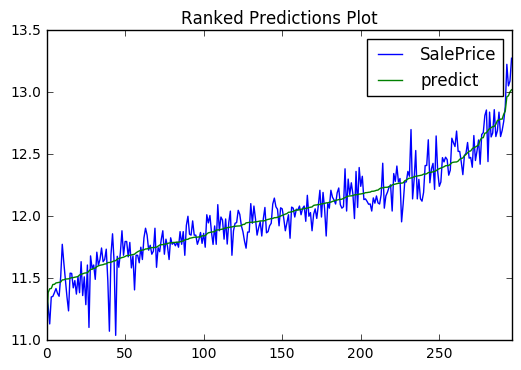

In [21]:
glm1 = glm_grid(encoded_nums, 'SalePrice', base_train, base_valid)

#### Third model on encoded numeric inputs

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.01]  Grid_GLM_py_191_sid_8fab_model_python_1495746557457_3_model_0   
1     [0.5]  Grid_GLM_py_191_sid_8fab_model_python_1495746557457_3_model_2   
2    [0.25]  Grid_GLM_py_191_sid_8fab_model_python_1495746557457_3_model_1   
3    [0.99]  Grid_GLM_py_191_sid_8fab_model_python_1495746557457_3_model_3   

    residual_deviance  
0   4.091170957722615  
1  4.1307790816385985  
2   4.136887122640834  
3    4.15333560540564  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_191_sid_8fab_model_python_1495746557457_3_model_0
GLM Model: summary



,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,"Elastic Net (alpha = 0.01, lambda = 0.3669 )","nlambda = 100, lambda.max = 35.024, lambda.min = 0.3669, lambda.1se = -1.0",3151,658,0,py_191_sid_8fab




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.01223770429690285
RMSE: 0.11062415783590332
MAE: 0.07934598548374366
RMSLE: 0.008635892027094846
R^2: 0.9307840245589295
Mean Residual Deviance: 0.01223770429690285
Null degrees of freedom: 440
Residual degrees of freedom: -218
Null deviance: 77.97083780937984
Residual deviance: 5.396827594934157
AIC: 629.677778859672

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 0.013774986389638434
RMSE: 0.11736688796095104
MAE: 0.08257016399533915
RMSLE: 0.009137199156759437
R^2: 0.9074463920728737
Mean Residual Deviance: 0.013774986389638434
Null degrees of freedom: 296
Residual degrees of freedom: -362
Null deviance: 44.26529427591359
Residual deviance: 4.091170957722615
AIC: 890.2339178620487
Scoring History: 


,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-05-25 17:10:04,0.000 sec,0,.33E2,29,0.1743073,0.1468126
,2017-05-25 17:10:04,0.033 sec,0,.32E2,44,0.1688166,0.1419290
,2017-05-25 17:10:04,0.064 sec,0,.3E2,67,0.1619606,0.1358494
,2017-05-25 17:10:04,0.096 sec,0,.29E2,91,0.1543317,0.1290774
,2017-05-25 17:10:04,0.136 sec,0,.28E2,113,0.1464611,0.1221023
---,---,---,---,---,---,---,---
,2017-05-25 17:10:15,10.964 sec,0,.42E0,661,0.0127990,0.0137823
,2017-05-25 17:10:15,11.268 sec,0,.4E0,663,0.0126152,0.0137772
,2017-05-25 17:10:15,11.570 sec,0,.38E0,664,0.0124275,0.0137763
,2017-05-25 17:10:16,11.904 sec,0,.37E0,659,0.0122377,0.0137750



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
12.109,12.2035
11.7745,11.847
11.964,11.7388
12.6925,12.7849
11.9447,11.9287
12.1002,12.1819
12.6411,12.6814
11.8776,11.9034
11.7772,11.8114
12.428,12.3918


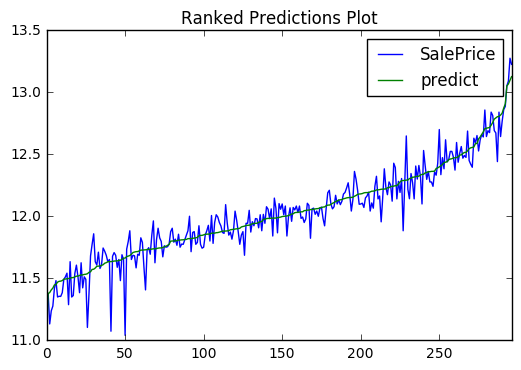

In [22]:
glm2 = glm_grid(encoded_combined_nums, 'SalePrice', base_train, base_valid)

## Train combiner model on second level data

#### Add prediction features to second level data and test data

In [23]:
stack_train = stack_train.cbind(glm0.predict(stack_train))
stack_valid = stack_valid.cbind(glm0.predict(stack_valid))
stack_train = stack_train.cbind(glm1.predict(stack_train))
stack_valid = stack_valid.cbind(glm1.predict(stack_valid))
stack_train = stack_train.cbind(glm2.predict(stack_train))
stack_valid = stack_valid.cbind(glm2.predict(stack_valid))

test = test.cbind(glm0.predict(test))
test = test.cbind(glm1.predict(test))
test = test.cbind(glm2.predict(test))

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


#### Train stack model

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.25]  Grid_GLM_py_213_sid_8fab_model_python_1495746557457_4_model_1   
1     [0.5]  Grid_GLM_py_213_sid_8fab_model_python_1495746557457_4_model_2   
2    [0.01]  Grid_GLM_py_213_sid_8fab_model_python_1495746557457_4_model_0   
3    [0.99]  Grid_GLM_py_213_sid_8fab_model_python_1495746557457_4_model_3   

    residual_deviance  
0  3.6932423487778956  
1   3.712234438259141  
2  3.7193754805202603  
3  3.7423849687875306  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_213_sid_8fab_model_python_1495746557457_4_model_1
GLM Model: summary



,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,"Elastic Net (alpha = 0.25, lambda = 0.01514 )","nlambda = 100, lambda.max = 1.4452, lambda.min = 0.01514, lambda.1se = -1.0",3147,113,0,py_213_sid_8fab




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.008800027588389986
RMSE: 0.09380846224296605
MAE: 0.06777815128504515
RMSLE: 0.007327223820960532
R^2: 0.9396325859664474
Mean Residual Deviance: 0.008800027588389986
Null degrees of freedom: 424
Residual degrees of freedom: 311
Null deviance: 61.95414835869291
Residual deviance: 3.7400117250657443
AIC: -575.4274263209222

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 0.012435159423494598
RMSE: 0.11151304597891046
MAE: 0.07930523355116216
RMSLE: 0.008677346703446916
R^2: 0.9239086899175499
Mean Residual Deviance: 0.012435159423494598
Null degrees of freedom: 296
Residual degrees of freedom: 183
Null deviance: 48.54731789836815
Residual deviance: 3.6932423487778956
AIC: -230.15704351139948
Scoring History: 


,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-05-25 17:10:45,0.000 sec,0,.14E1,3,0.1388403,0.1557921
,2017-05-25 17:10:45,0.024 sec,0,.13E1,4,0.1306875,0.1468525
,2017-05-25 17:10:45,0.049 sec,0,.13E1,4,0.1228839,0.1382948
,2017-05-25 17:10:45,0.072 sec,0,.12E1,4,0.1155327,0.1302237
,2017-05-25 17:10:45,0.094 sec,0,.11E1,4,0.1086090,0.1226119
---,---,---,---,---,---,---,---
,2017-05-25 17:10:49,3.897 sec,0,.17E-1,113,0.0091258,0.0124389
,2017-05-25 17:10:49,3.963 sec,0,.17E-1,114,0.0090110,0.0124383
,2017-05-25 17:10:49,4.029 sec,0,.16E-1,111,0.0089025,0.0124362
,2017-05-25 17:10:49,4.099 sec,0,.15E-1,114,0.0088000,0.0124352



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,12.0678
12.2061,12.3727
11.9117,12.0015
11.9767,11.9516
11.8451,11.8503
11.914,11.7571
11.8565,11.7275
12.6758,12.4637
12.861,12.5652
12.1035,12.1022


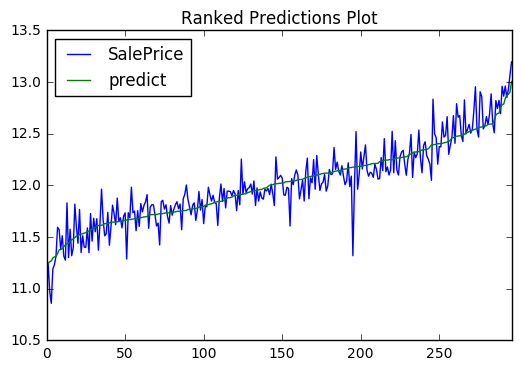

In [24]:
glm3 = glm_grid(encoded_combined_nums + ['predict', 'predict0', 'predict1'], 'SalePrice', stack_train, stack_valid)

#### Score test data

In [25]:
sub = test['Id'].cbind(glm3.predict(test))
sub['predict'] = sub['predict'].exp()
print(sub.head())

glm prediction progress: |████████████████████████████████████████████████| 100%


Id,predict
1461,110449
1462,146047
1463,162483
1464,191073
1465,187437
1466,164979
1467,178334
1468,157765
1469,185923
1470,118524


#### Create submission

In [26]:
# create time stamp
import re
import time
time_stamp = re.sub('[: ]', '_', time.asctime())

# save file for submission
sub.columns = ['Id', 'SalePrice']
sub_fname = '../data/submission_' + str(time_stamp) + '.csv'
h2o.download_csv(sub, sub_fname)

In [27]:
# Shutdown H2O - this will erase all your unsaved frames and models in H2O
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_8fab closed.
